#### Policy Gradient

In [1]:
%matplotlib ipympl

import numpy as np
import tensorflow as tf
from tensorflow import keras
import gymnasium

import ale_py
import matplotlib.animation as animation
import matplotlib.pyplot as plt

from livelossplot import PlotLossesKeras, PlotLosses

from collections import deque
tf.keras.utils.disable_interactive_logging()

2024-12-12 11:35:54.951757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 11:35:56.427150: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick/miniconda3/envs/tf_env/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/nick/miniconda3/envs/tf_env/lib/
2024-12-12 11:35:56.427477: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick

In [2]:
env = gymnasium.make("LunarLander-v3")

In [3]:
loss_fn = keras.losses.sparse_categorical_crossentropy
optimizer = keras.optimizers.Adam(learning_rate=0.005)

n_iterations = 200
update_period = 16
n_max_steps = 1000
discount_rate = 0.99

In [4]:
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(n_outputs, activation="softmax")
])


In [5]:
def play_one_step(obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, terminated, truncated, _ = env.step(action[0,0].numpy())
    done = terminated or truncated
    return grads, reward, done, obs

In [6]:
def play_multiple_episodes(env, model, n_episodes, n_steps, loss_fn):
    all_grads = []
    all_rewards = []
    for episode in range(n_episodes):
        current_grads = []
        current_rewards = []
        obs, _ = env.reset()
        for step in range(n_steps):
            grads, reward, done, obs = play_one_step(obs, model, loss_fn)
            current_grads.append(grads)
            current_rewards.append(reward)
            if done:
                break
        all_grads.append(current_grads)
        all_rewards.append(current_rewards)
    return all_grads, all_rewards

In [7]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted
    

def discount_normalize(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) 
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [8]:
mean_rewards = []
for iteration in range(n_iterations):
    keras.backend.clear_session()
    all_grads, all_rewards = play_multiple_episodes(env, model, update_period, n_max_steps, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / update_period
    print(f"\rIteration: {iteration + 1}, mean rewards: {mean_reward}",end="")
    mean_rewards.append(mean_reward)
    all_normalized_rewards = discount_normalize(all_rewards, discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean([reward * all_grads[episode][step][var_index]
                                    for episode, rewards in enumerate(all_normalized_rewards) 
                                        for step, reward in enumerate(rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 1, mean rewards: -185.3909669092668WARNING:tensorflow:5 out of the last 5 calls to <function _BaseOptimizer._update_step_xla at 0x7f60b2997e50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Iteration: 200, mean rewards: 146.16817107635467

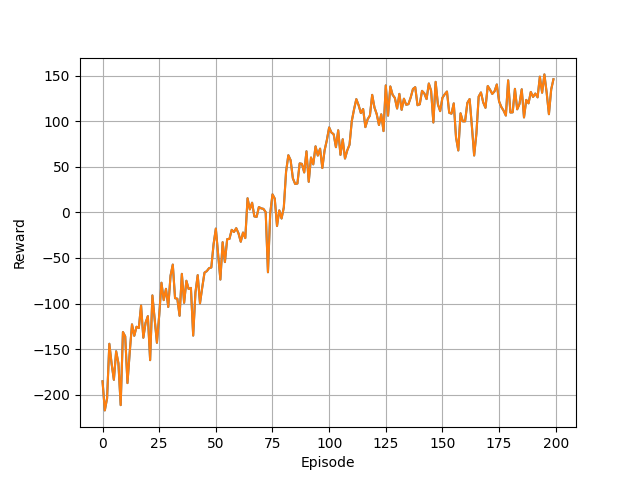

In [10]:
plt.plot(mean_rewards)
plt.grid()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()